In [66]:
###############################################################################
# 0. Chargement des librairies
###############################################################################
library(glmnet)
library(corrplot)
library(pheatmap)
library(FactoMineR)
library(factoextra)
library(caret)
library(pls)


Attaching package: ‘pls’


The following object is masked from ‘package:caret’:

    R2


The following object is masked from ‘package:corrplot’:

    corrplot


The following object is masked from ‘package:stats’:

    loadings




In [4]:
###############################################################################
# 1. Extraction des données brutes
###############################################################################
data_weather <- read.table("data/donnees-synop-essentielles-omm.csv",
                        header = TRUE,
                        sep = ";",
                        quote = "\"")

cat("Dimensions initiales :", dim(data_weather), "\n")


Dimensions initiales : 1719567 82 


In [ ]:


# ###############################################################################
# # 2. Filtrage — Focus sur une station météo (Nice, ID = 7181)
# ###############################################################################
# data_weather_nice <- data_weather[data_weather$ID.OMM.station == "7181", ]
# cat("Dimensions après filtrage station 7181 :", dim(data_weather_nice), "\n")


###############################################################################
# 3. Nettoyage — Garder uniquement les colonnes numériques + imputation NA
###############################################################################
# Sélection numérique uniquement
df_num <- data_weather[, sapply(data_weather, is.numeric)]

# Suppression des colonnes constantes (variance nulle)
df_num <- df_num[, apply(df_num, 2, function(x) length(unique(na.omit(x))) > 1)]

# Imputation des NA par la moyenne 
# C'est une méthode simple, mais elle peut mener à des biais.
# On réduira par la suite le nombre de features.
# On pourra alors enlever les lignes avec NA et garder une dataset propre.
for (col in names(df_num)) {
  df_num[is.na(df_num[[col]]), col] <- mean(df_num[[col]], na.rm = TRUE)
}

cat("Dimensions après nettoyage :", dim(df_num), "\n")

#TODO : A AMELIORER AVEC CODE DE JULES 

Dimensions après nettoyage : 1719567 63 


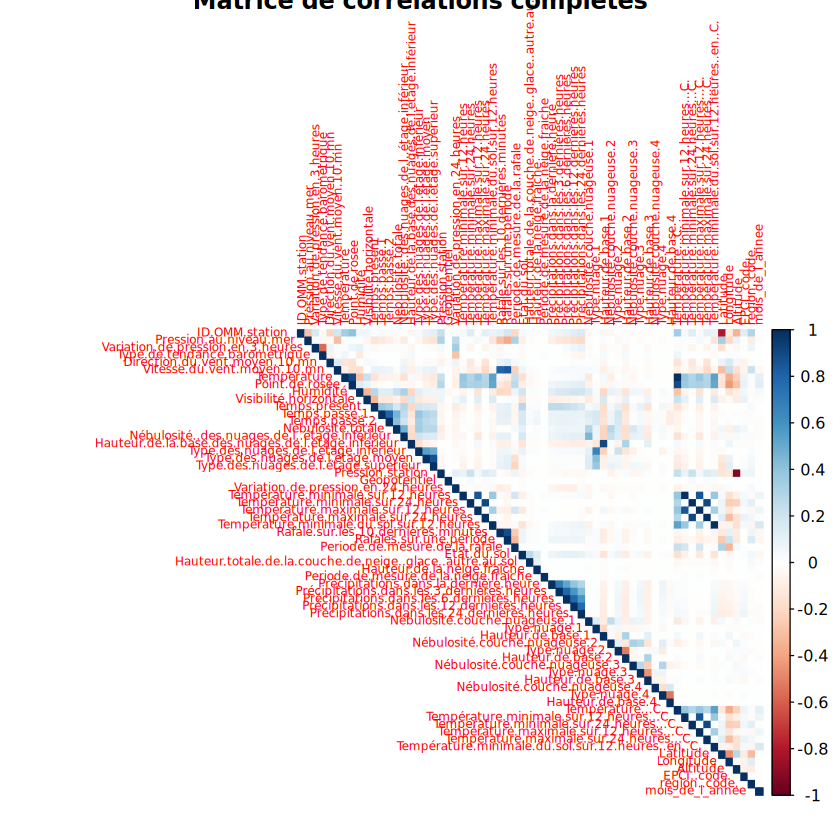

In [14]:
###############################################################################
# 4. Analyse des corrélations structurée
###############################################################################
par(bg = "white")

# 4.1 Corrélation brute + Heatmap
cor_mat <- cor(df_num, use = "pairwise.complete.obs")
corrplot(cor_mat, method = "color", type = "upper", tl.cex = 0.6,
         main = "Matrice de corrélations complètes")


On observe plusieurs corrélations, on va regarder en détail ce qu'il en est


Top corrélations toutes variables confondues (>| 0.8 |):


,var1,var2,corr
,<chr>,<chr>,<dbl>
9,Température,Température...C.,1.000
11,Température.minimale.sur.12.heures,Température.minimale.sur.12.heures...C.,1.000
13,Température.minimale.sur.24.heures,Température.minimale.sur.24.heures...C.,1.000
16,Température.maximale.sur.12.heures,Température.maximale.sur.12.heures...C.,1.000
19,Température.maximale.sur.24.heures,Température.maximale.sur.24.heures...C.,1.000
21,Température.minimale.du.sol.sur.12.heures,Température.minimale.du.sol.sur.12.heures..en..C.,1.000
23,Pression.station,Altitude,-0.920
5,Température.minimale.sur.24.heures,Température.maximale.sur.24.heures,0.910
14,Température.maximale.sur.24.heures,Température.minimale.sur.24.heures...C.,0.910


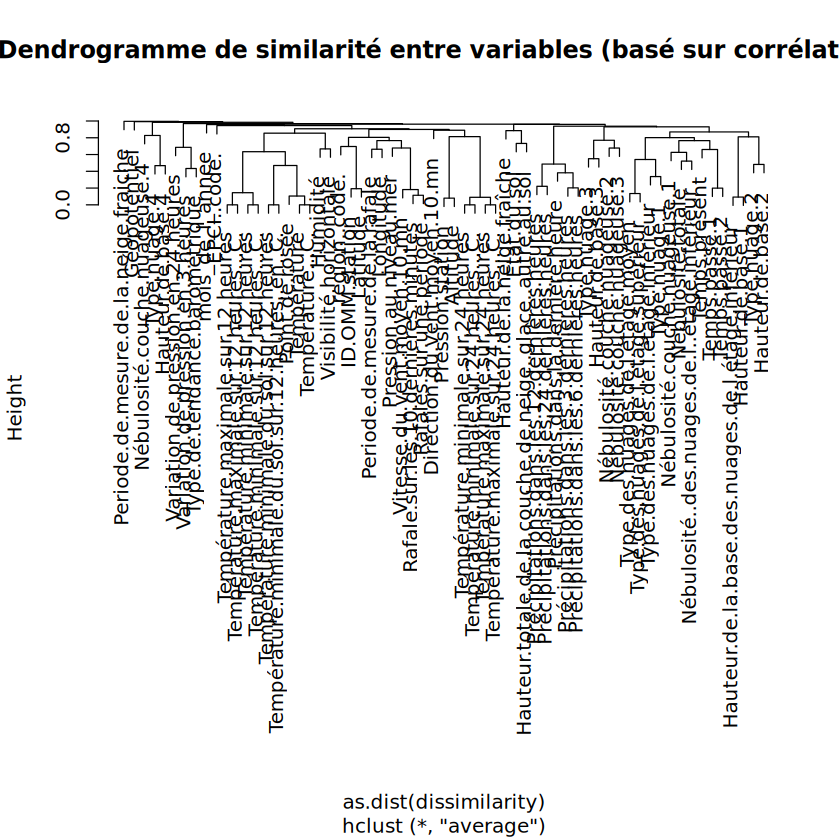

In [23]:
# 4.2 Extraction des corrélations fortes (positives & négatives)
cor_threshold <- 0.8
cor_mat_abs <- abs(cor_mat)
cor_mat_abs[lower.tri(cor_mat_abs, diag = TRUE)] <- 0

strong_corr <- which(cor_mat_abs > cor_threshold, arr.ind = TRUE)

corr_df <- data.frame(
  var1 = rownames(cor_mat_abs)[strong_corr[,1]],
  var2 = colnames(cor_mat_abs)[strong_corr[,2]],
  corr = round(cor_mat[strong_corr], 3)
)

corr_df <- corr_df[order(-abs(corr_df$corr)), ]
cat("\nTop corrélations toutes variables confondues (>|",cor_threshold,"|):\n")
head(corr_df, 30)



par(bg = "white")

# 4.3 Arbre hiérarchique des variables selon corrélation
dissimilarity <- 1 - abs(cor_mat)     # distance = 1 - |corr|
hc <- hclust(as.dist(dissimilarity), method = "average")

plot(hc, main = "Dendrogramme de similarité entre variables (basé sur corrélation)")

On réalise que la majorité des grosses corrélations sont logiques et représentent des variables qui mesure sensiblement la même chose

On va donc procéder à une analyse métier pour réduire grandement le nombre de features. Arbitrairement on choisit une dizaine de features qui nous semble intéressantes à étudier.

In [38]:
###############################################################################
# 4bis. Filtrage grâce à la correlation 
###############################################################################

selected_data <- data_weather[, c(0,1,2,3,7,8,9,10,11,15,17,23,71,72,73)]
head(selected_data)


,ID.OMM.station,Date,Pression.au.niveau.mer,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,Visibilité.horizontale,Nebulosité.totale,Hauteur.de.la.base.des.nuages.de.l.étage.inférieur,Géopotentiel,Latitude,Longitude,Altitude
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>
1,7690,2017-04-05T11:00:00+02:00,101580,1.3,289.95,285.25,74,15000,75,450,NA,43.64883,7.209000,2
2,61998,2017-04-05T11:00:00+02:00,102720,20.1,285.65,281.95,78,NA,NA,NA,NA,-49.35233,70.243333,29
3,78925,2018-04-04T05:00:00+02:00,101420,3.6,298.45,295.15,82,60000,90,800,NA,14.59533,-60.995667,3
4,61998,2018-04-05T05:00:00+02:00,101190,5.1,278.15,272.75,68,NA,NA,NA,NA,-49.35233,70.243333,29
5,7690,2018-04-05T08:00:00+02:00,101240,1.6,284.25,280.15,76,20000,60,NA,NA,43.64883,7.209000,2
6,7149,2018-04-08T05:00:00+02:00,100730,2.3,285.55,283.25,86,25000,90,3300,NA,48.71683,2.384333,89


## PCA :
We are filtering the dataset on only one station, at Nice

In [43]:
###############################################################################
# 2. Filtrage — Focus sur une station météo (Nice, ID = 7181)
###############################################################################

data_weather_nice <- selected_data[selected_data$ID.OMM.station == "7181", ]

cat("Dimensions après filtrage station 7181 :", dim(data_weather_nice), "\n")

###############################################################################
# 3. Nettoyage — Garder uniquement les colonnes numériques + imputation NA
###############################################################################

# Sélection numérique uniquement
df_num <- data_weather_nice[, sapply(data_weather_nice, is.numeric)]

# Suppression des colonnes constantes (variance nulle)
df_num <- df_num[, apply(df_num, 2, function(x) length(unique(na.omit(x))) > 1)]

# Suppression des lignes contenant au moins un NA
df_num <- na.omit(df_num)

cat("Dimensions après nettoyage :", dim(df_num), "\n")




Dimensions après filtrage station 7181 : 29310 14 
Dimensions après nettoyage : 16952 8 


,Pression.au.niveau.mer,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,Visibilité.horizontale,Nebulosité.totale,Hauteur.de.la.base.des.nuages.de.l.étage.inférieur
Pression.au.niveau.mer,1.00,-0.34,-0.17,-0.17,0.07,-0.17,0.00,-0.04
Vitesse.du.vent.moyen.10.mn,-0.34,1.00,0.05,0.00,-0.14,0.15,0.03,-0.13
Température,-0.17,0.05,1.00,0.87,-0.55,0.39,-0.25,0.30
Point.de.rosée,-0.17,0.00,0.87,1.00,-0.08,0.19,-0.11,0.11
Humidité,0.07,-0.14,-0.55,-0.08,1.00,-0.53,0.31,-0.44
Visibilité.horizontale,-0.17,0.15,0.39,0.19,-0.53,1.00,-0.18,0.36
Nebulosité.totale,0.00,0.03,-0.25,-0.11,0.31,-0.18,1.00,-0.22
Hauteur.de.la.base.des.nuages.de.l.étage.inférieur,-0.04,-0.13,0.30,0.11,-0.44,0.36,-0.22,1.00


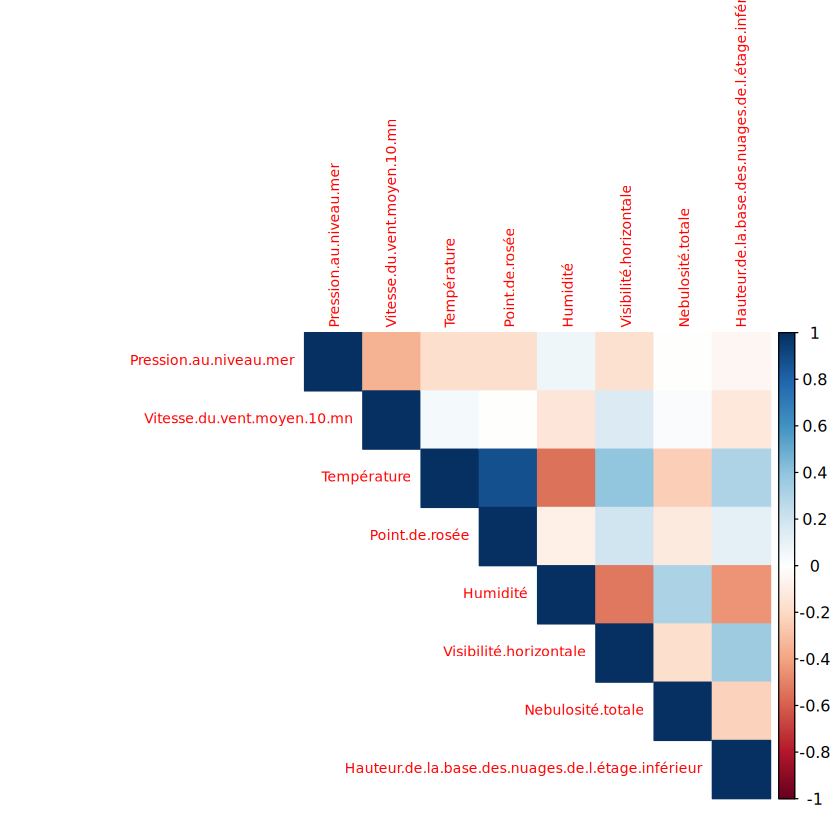

In [48]:
#D'abord, calculons la matrice de corrélarion pour voir les relations entre les variables
par(bg = "white") 
cor_mat <- cor(df_num, use = "pairwise.complete.obs")  # corrélation entre toutes les variables
round(cor_mat, 2)
library(corrplot)
corrplot(cor_mat, method = "color", type = "upper", tl.cex = 0.7) 


Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6    PC7
Standard deviation     1.6657 1.1804 1.1310 0.9165 0.85606 0.72693 0.6699
Proportion of Variance 0.3468 0.1742 0.1599 0.1050 0.09161 0.06605 0.0561
Cumulative Proportion  0.3468 0.5210 0.6809 0.7859 0.87747 0.94352 0.9996
                           PC8
Standard deviation     0.05515
Proportion of Variance 0.00038
Cumulative Proportion  1.00000


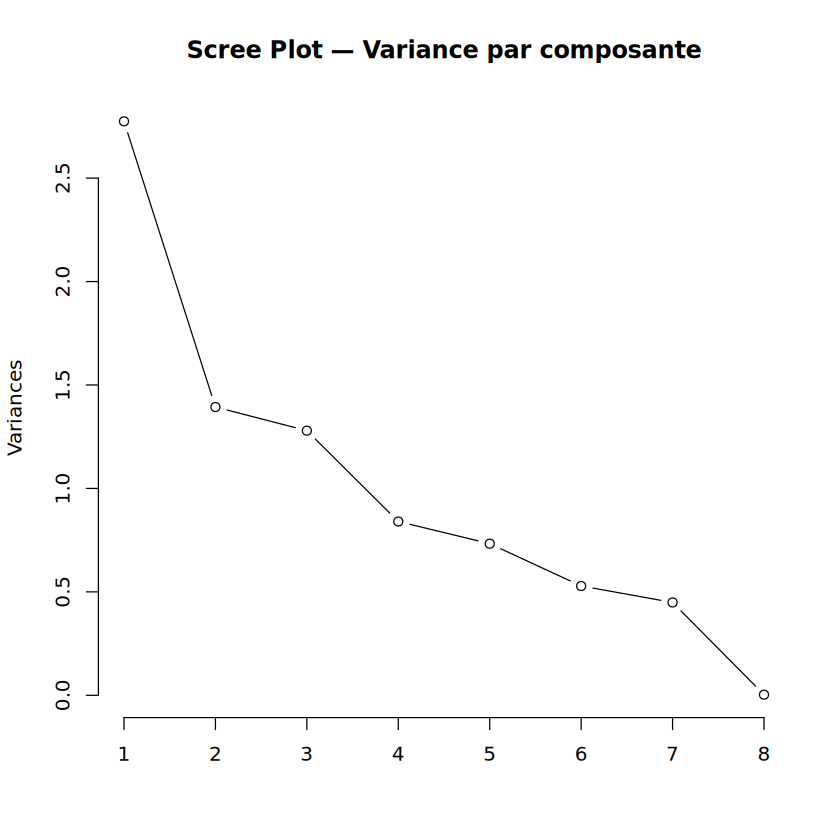

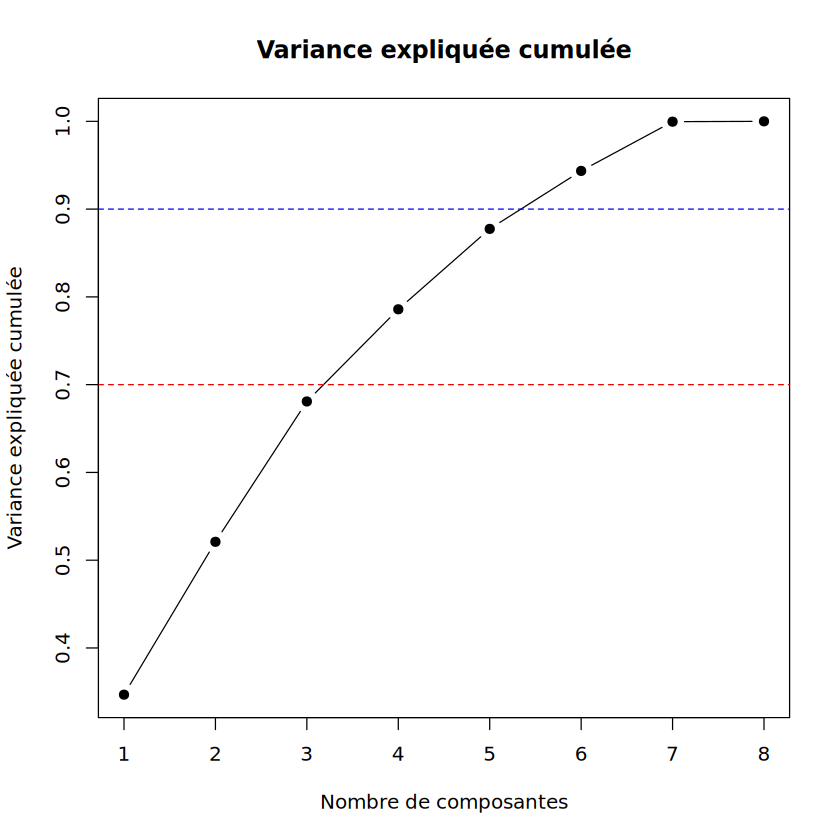

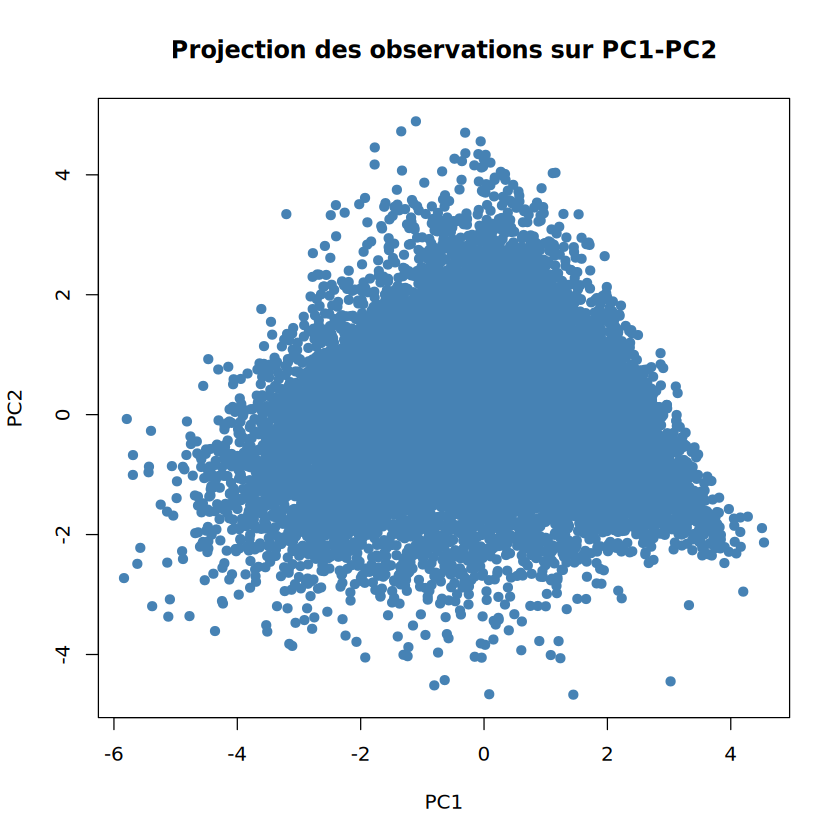

In [50]:
par(bg="white")
df_scaled <- scale(df_num)
pca_res <- prcomp(df_scaled, center = TRUE, scale. = TRUE)

# Question : Quelle part de la structure totale est capturée par la PCA ?
print(summary(pca_res))

# 5.1 Quelle est l’importance relative de chaque composante ? (Scree Plot)
plot(pca_res, type = "l", main = "Scree Plot — Variance par composante")

# 5.2 Combien de composantes faut-il pour résumer 70 % / 90 % de la variance ?
var_explained <- cumsum(pca_res$sdev^2 / sum(pca_res$sdev^2))
plot(var_explained, type = "b", pch = 19, 
     xlab = "Nombre de composantes", 
     ylab = "Variance expliquée cumulée",
     main = "Variance expliquée cumulée")
abline(h = 0.7, col = "red", lty = 2)   # Seuil 70 %
abline(h = 0.9, col = "blue", lty = 2)  # Seuil 90 %

# 5.3 À quoi ressemble la structure globale ? (projection des observations)
scores <- pca_res$x
plot(scores[,1], scores[,2],
     xlab = "PC1", ylab = "PC2",
     main = "Projection des observations sur PC1-PC2",
     pch = 19, col = "steelblue")


PC1 est principalement défini par :
                                       Température 
                                         0.5265341 
                                          Humidité 
                                         0.4442430 
                            Visibilité.horizontale 
                                         0.4077932 
                                    Point.de.rosée 
                                         0.3784002 
Hauteur.de.la.base.des.nuages.de.l.étage.inférieur 
                                         0.3370907 

PC2 est principalement défini par :
                       Vitesse.du.vent.moyen.10.mn 
                                         0.5892095 
                            Pression.au.niveau.mer 
                                         0.5827066 
Hauteur.de.la.base.des.nuages.de.l.étage.inférieur 
                                         0.3710286 
                                 Nebulosité.totale 
                                         0

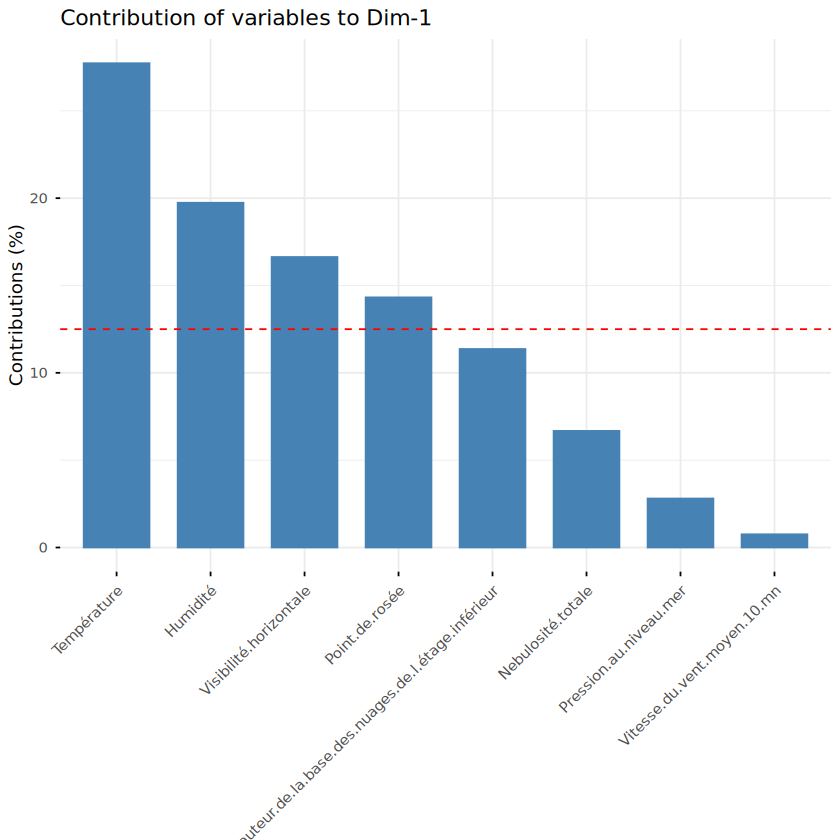


⚑ Interprétation suggérée :
• PC1 oppose : Température vs Hauteur.de.la.base.des.nuages.de.l.étage.inférieur 
• PC2 oppose : Vitesse.du.vent.moyen.10.mn vs Point.de.rosée 


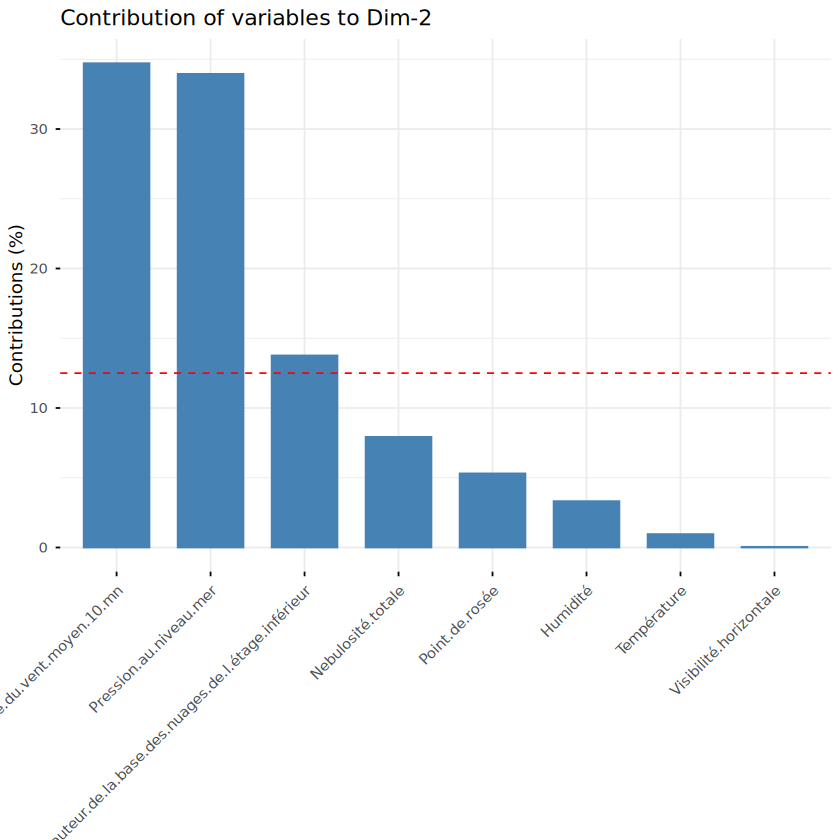

In [53]:
###############################################################################
# 6. Interprétation des axes — Que représentent PC1 et PC2 ?
###############################################################################

# 6.1 Quelles variables définissent principalement chaque axe ?
loadings <- pca_res$rotation
top_dim1 <- sort(abs(loadings[,1]), decreasing = TRUE)[1:5]
top_dim2 <- sort(abs(loadings[,2]), decreasing = TRUE)[1:5]

cat("\nPC1 est principalement défini par :\n")
print(top_dim1)

cat("\nPC2 est principalement défini par :\n")
print(top_dim2)

fviz_contrib(pca_res, choice = "var", axes = 1, top = 10)
fviz_contrib(pca_res, choice = "var", axes = 2, top = 10)

# 6.2 Conclusion automatique
cat("\n⚑ Interprétation suggérée :\n")
cat("• PC1 oppose :", names(top_dim1[1]), "vs", names(top_dim1[length(top_dim1)]), "\n")
cat("• PC2 oppose :", names(top_dim2[1]), "vs", names(top_dim2[length(top_dim2)]), "\n")


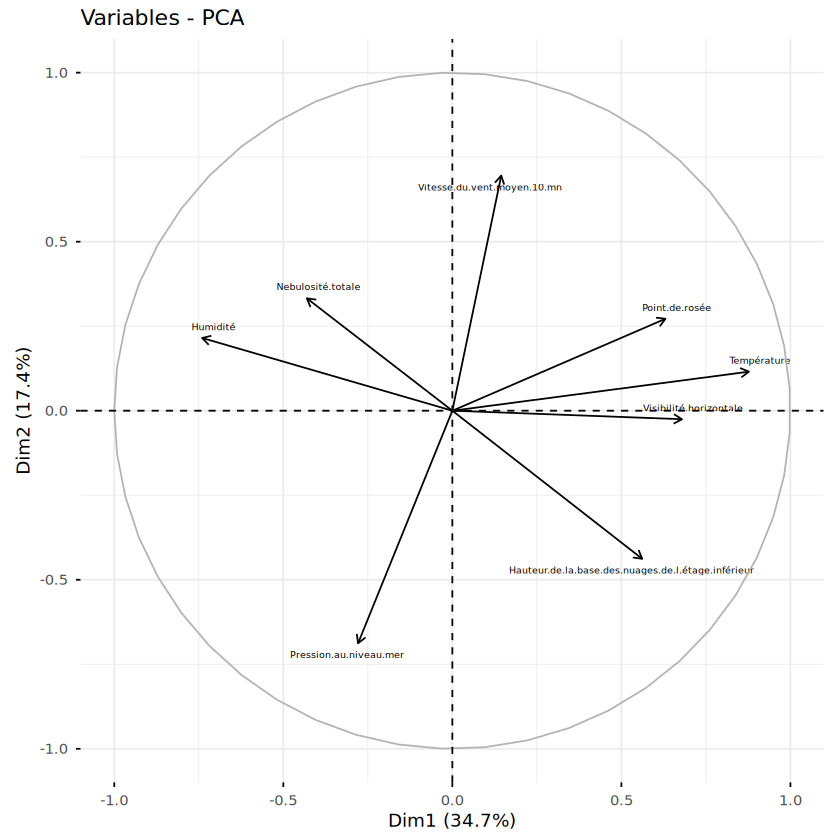

In [69]:
res.pca <- PCA(df_num, scale.unit = TRUE, graph = FALSE)

# Cercle des corrélations pour PC1 et PC2
fviz_pca_var(res.pca, 
             axes = c(1, 2), 
             repel = TRUE, 
             labelsize = 2)

On voit que Température et Humidité sont anti-corrélés donc on va faire afficher les points

On fera la même chose pour Température - Point de rosée et Humidité - Visibilité

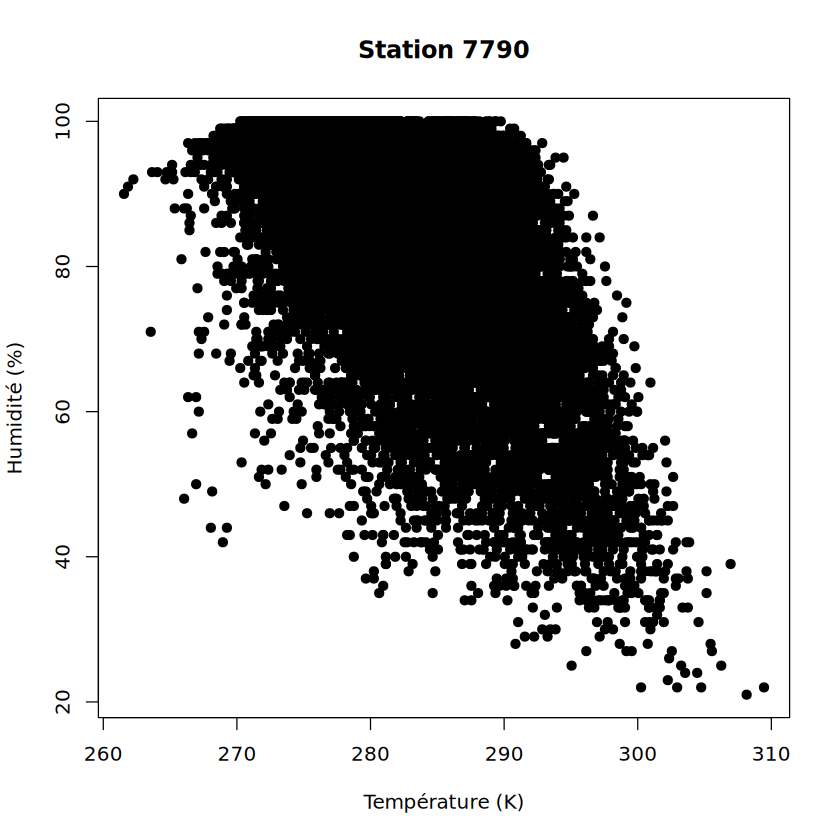

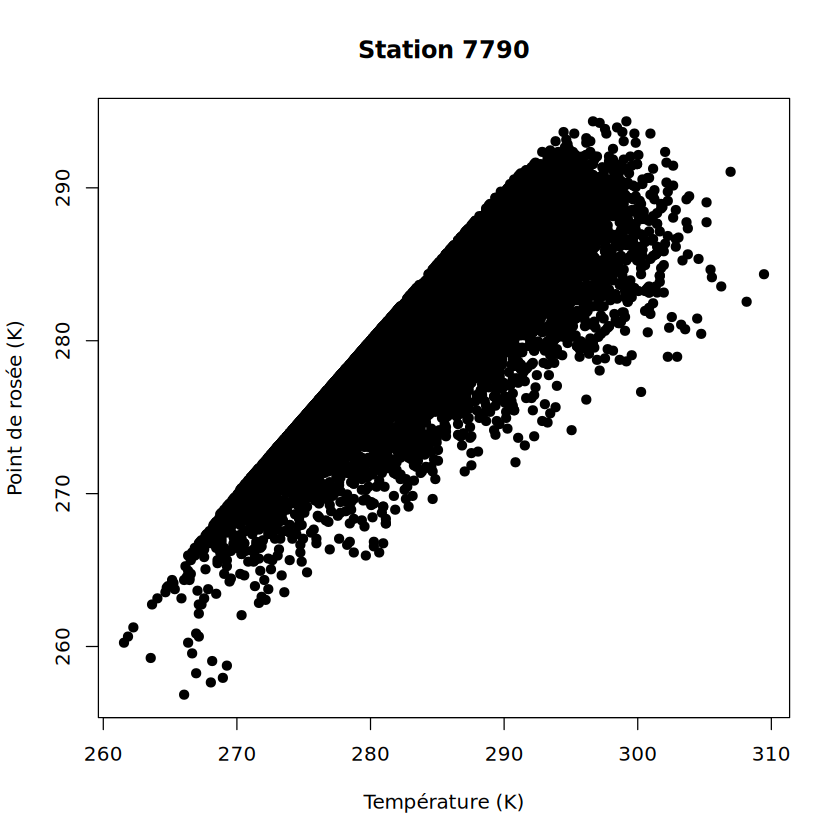

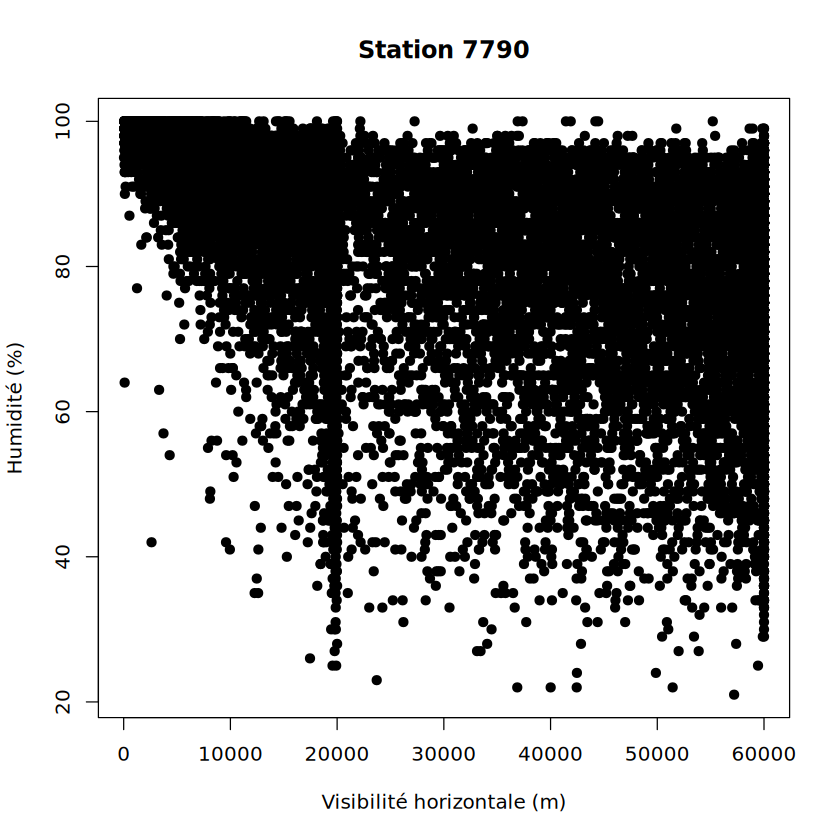

In [57]:
par(bg = "white")
plot(df_num$`Température`, 
    df_num$`Humidité`, 
    type = "p",
    xlab = "Température (K)", 
    ylab = "Humidité (%)", 
    main = "Station 7790",
    pch = 19,)

plot(df_num$`Température`, 
    df_num$`Point.de.rosée`, 
    type = "p",
    xlab = "Température (K)", 
    ylab = "Point de rosée (K)", 
    main = "Station 7790",
    pch = 19,)

plot(df_num$`Visibilité.horizontale`, 
    df_num$`Humidité`, 
    type = "p",
    xlab = "Visibilité horizontale (m)", 
    ylab = "Humidité (%)", 
    main = "Station 7790",
    pch = 19,)

Il y a effectivement une corrélation entre Température et Humidité, ainsi qu'entre Température et Point de rosée, comme prévu.

Cependant, c'est moins clair pour Humidité - Visibilité. Cela s'explique car l'intuition qu'on a eu était sur la représentation des features sur les deux premières composantes principales. Or, on a vu précedemment qu'elles expliquent à peine plus de 50% de la variance. Il faudrait donc prendre plus de composantes principales pour réaliser qu'ils ne sont enfait que très peu corrélés

# Régression LASSO

Nous allons déterminer quels sont les features qui influent le plus sur l'Humidité. Nous savons déjà que la température va beaucoup jouer, mais vérifions si nous sommes passés à côté d'autres features.

,Pression.au.niveau.mer,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,Visibilité.horizontale,Nebulosité.totale,Hauteur.de.la.base.des.nuages.de.l.étage.inférieur
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
163,101250,4.3,292.45,284.95,62,22380,90,1250
233,101110,2.4,277.85,277.55,98,8370,100,150
730,102720,4.9,284.25,283.15,93,13710,100,450
814,101820,2.1,278.15,273.85,74,57830,100,1250
1581,101800,2.7,287.05,287.05,100,3760,100,80
1740,100920,3.5,272.65,272.25,97,4590,100,450


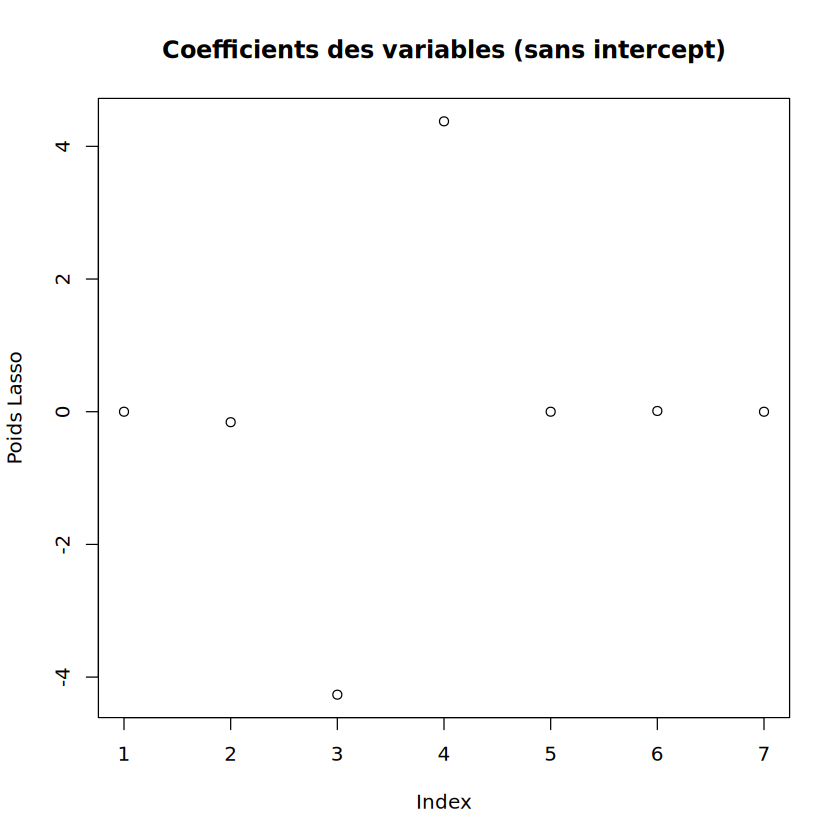

In [70]:
par(bg = "white")
# Variable cible
y <- df_num$`Humidité`

# Variables explicatives
X <- subset(df_num, select = -`Humidité`)

# Conversion en matrice (glmnet attend une matrice numérique)
X_mat <- model.matrix(~., data = X)[,-1]  # supprime l’intercept automatique

# --- Lasso avec validation croisée ---
set.seed(123)  # reproductibilité
cv_lasso <- cv.glmnet(X_mat, y, alpha = 1, nfolds = 10)

# --- Modèle final avec lambda optimal ---
lasso_model <- glmnet(X_mat, y, alpha = 1, lambda = cv_lasso$lambda.min)

# Coefficients retenus
coef_lasso <- coef(lasso_model)
# On enlève l'intercept (premier élément)
coef_vars <- as.vector(coef_lasso[-1])

# Visualisation des poids
plot(coef_vars, ylab = "Poids Lasso", main = "Coefficients des variables (sans intercept)")
head(df_num)


On remarque seulement 2 features largement dominantes qui influent sur l'humidité. La première est la Température, comme prévu. La seconde est le point de rosée, effectivement celui-ci est très corrélé à la température donc logiquement il est aussi correlé à l'humidité. On a donc montré que ce sont les deux seuls à avoir une influence notable sur l'humidité.

In [71]:
# 1. Conversion de df_scaled en data.frame

# 2. PLS multivariée
model_pls <- plsr(Point.de.rosée ~ ., data = df_num, center = TRUE, scale = TRUE)
# 3. PLS univariée
model_pls_temp <- plsr(Point.de.rosée ~ Température, data = df_num, center = TRUE, scale = TRUE)
# 4. Calcul des erreurs RMSEP
rmsep_pls <- RMSEP(model_pls)
rmsep_pls_temp <- RMSEP(model_pls_temp)
print(rmsep_pls)
print(rmsep_pls_temp)

(Intercept)      1 comps      2 comps      3 comps      4 comps      5 comps  
     5.5038       3.6169       1.2391       0.5996       0.5053       0.5045  
    6 comps      7 comps  
     0.5045       0.5045  
(Intercept)      1 comps  
      5.504        2.686  


# ANOVA
On va rajouter à notre dataframe les villes de Perros-Guirec (en Bretagne), et Poitiers en plus de Nice. Et nous allons regarder la Température et la vitesse du vent en fonction de la ville.


	Shapiro-Wilk normality test

data:  sample(residuals(anova_temp), 5000)
W = 0.99651, p-value = 1.858e-09



	Shapiro-Wilk normality test

data:  sample(residuals(anova_vent), 5000)
W = 0.93207, p-value < 2.2e-16


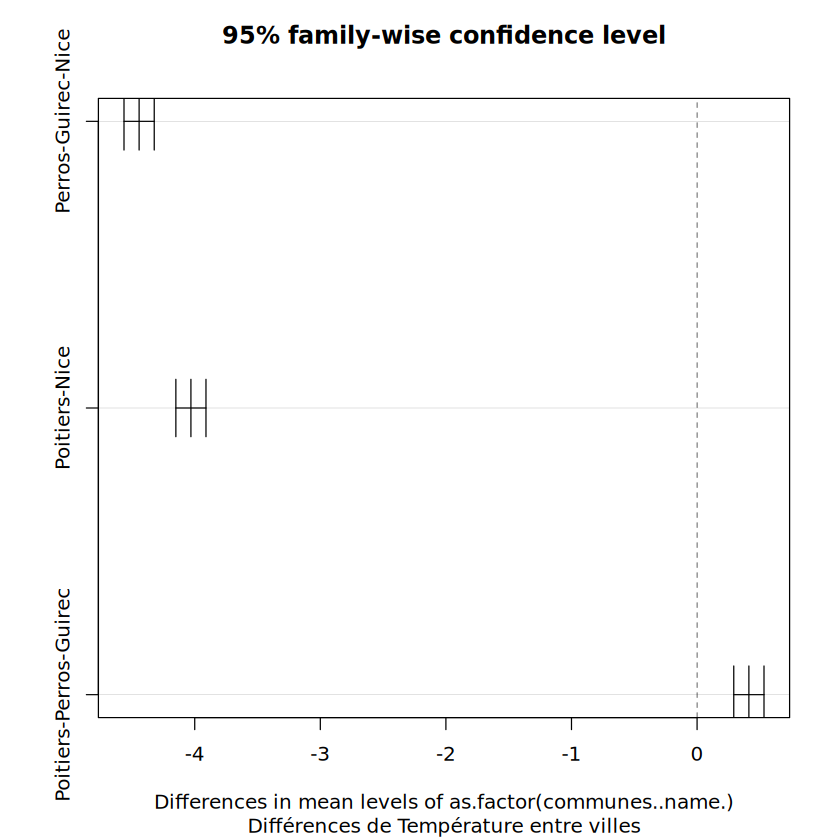

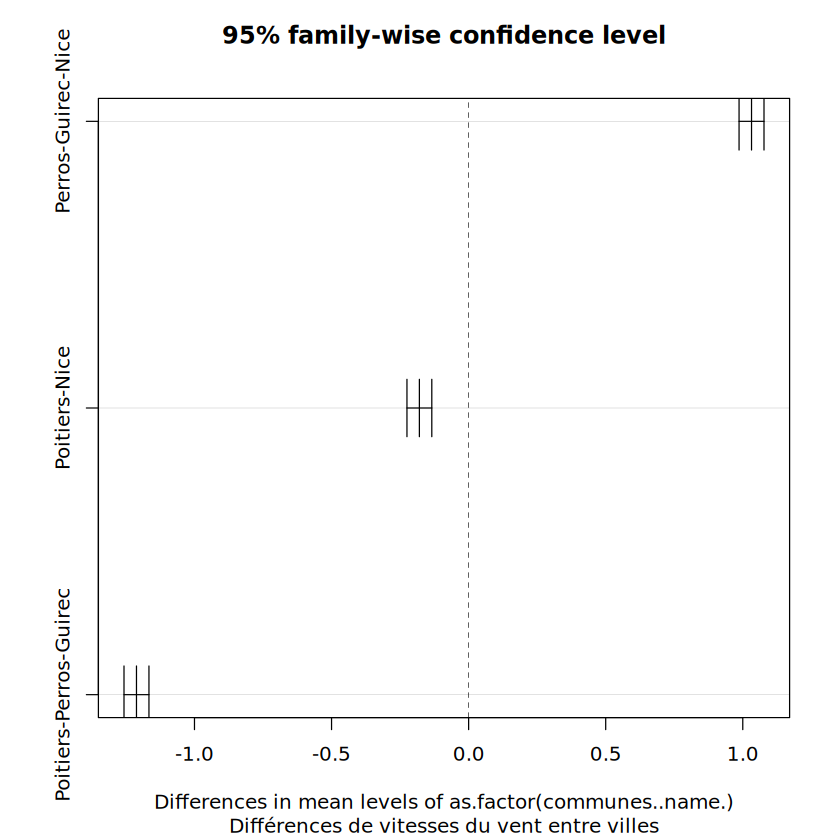

In [95]:
###############################################################################
# 1. Filtrage — Garder uniquement les villes d’intérêt : Nice, Perros-Guirec, Poitiers
###############################################################################

data_weather_anova <- data_weather[data_weather$communes..name. %in% 
                                     c("Nice", "Perros-Guirec", "Poitiers"), ]

test <- data_weather[data_weather$communes..name. %in% 
                                     c("Perros-Guirec", "Poitiers"), ]

###############################################################################
# 2. Sélection de colonnes pertinentes
###############################################################################

selected_data <- data_weather_anova[, c(7, 8, 74)]

###############################################################################
# 3. Nettoyage des données — imputation des valeurs manquantes par la moyenne
###############################################################################

# Suppression des lignes contenant au moins un NA
df_num <- na.omit(selected_data)

###############################################################################
# 4. ANOVA sur la Température par ville
###############################################################################

anova_temp <- aov(Température ~ as.factor(communes..name.), data = df_num)

# Vérification normalité des résidus
set.seed(123)
shapiro.test(sample(residuals(anova_temp), 5000))

# Post-hoc de Tukey si significatif
par(bg = "white")
plot(TukeyHSD(anova_temp))
mtext("Différences de Température entre villes", side = 1, line = 4)  


###############################################################################
# 5. ANOVA sur la Vitesse du vent moyen (10 mn) par ville
###############################################################################

anova_vent <- aov(Vitesse.du.vent.moyen.10.mn ~ as.factor(communes..name.), data = selected_data)


# Vérification normalité des résidus
set.seed(123)
shapiro.test(sample(residuals(anova_vent), 5000))

# Post-hoc de Tukey si significatif
par(bg = "white")
plot(TukeyHSD(anova_vent))
mtext("Différences de vitesses du vent entre villes", side = 1, line = 4)  



Concernant la température, on voit une différence notable Nice par rapport aux autres, il semble faire plus chaud en moyenne à Nice que dans les deux autres communes.

Quant à la vitesse du vent, c'est en bretagne qu'il y a une différence importante par rapport aux deux autres communes, cela s'explique bien sûr par l'océan à côté

# Création d'un estimateur de précipitation

Dans cette partie on va s'interesser aux précipitions, l'idée est de trouver "Quelle est la probabilité qu’il pleuve un jour donné, selon le mois de l’année ? Existe-t-il une saisonnalité nette dans la fréquence des précipitations ?", pour cela on va utiliser un  estimateur simple. L'idée est de d'utiliser une variable de bernouilli valant 1 si il pleut dans la journée, 0 sinon. on choisit l'estimateur comme la proportion de jour de pluie/ le nb de jours observé 
Quelques limites à cette méthodes au nombre de 3 : on prends pas en compte l'intensité (1mm comme 50mm compte pour 1), on considère les jours comme indépendant alors qu'il est possible d'avoir des jours consécutif  de pluie possiblement du à une autocorrelation et finalement on mets toutes les années et toutes les statiosn ensembles. On va commencer une deuxième partie ensuite où on segmentera par mois et par année et c'est facilement extrapolable avec la station aussi. 
L'avantage est que le nombre d'observation est très grand en conséquence réduisant fortement les intervella de confiaince, la méthode est d'autant plus pertinente qu'on cherche à mesurer une fréquence, ce qui est cohérent avec une variable binaire type bernouille, la proportoin empirique est logique dans ce cas et permet d'être facilement interprétable 

   month      n rainy_days     p_hat  ci_lower  ci_upper
1      1 145866      70084 0.4804684 0.4779014 0.4830361
2      2 132228      61043 0.4616496 0.4589596 0.4643412
3      3 145570      64511 0.4431614 0.4406072 0.4457178
4      4 139677      57884 0.4144133 0.4118280 0.4170020
5      5 144020      62448 0.4336064 0.4310449 0.4361707
6      6 139666      59305 0.4246202 0.4220259 0.4272176
7      7 144086      53068 0.3683078 0.3658165 0.3708045
8      8 157576      56802 0.3604737 0.3581024 0.3628501
9      9 141888      57187 0.4030432 0.4004895 0.4056010
10    10 144242      65681 0.4553528 0.4527803 0.4579272
11    11 139747      68917 0.4931555 0.4905308 0.4957804
12    12 145001      70147 0.4837691 0.4811938 0.4863450
     season      n rainy_days     p_hat
1 Printemps 429267     184843 0.4306015
2   Automne 703971     322912 0.4587007
3       Été 441328     169175 0.3833317
4     Hiver 145001      70147 0.4837691
   year     n rainy_days     p_hat
1  2016 14054       4816

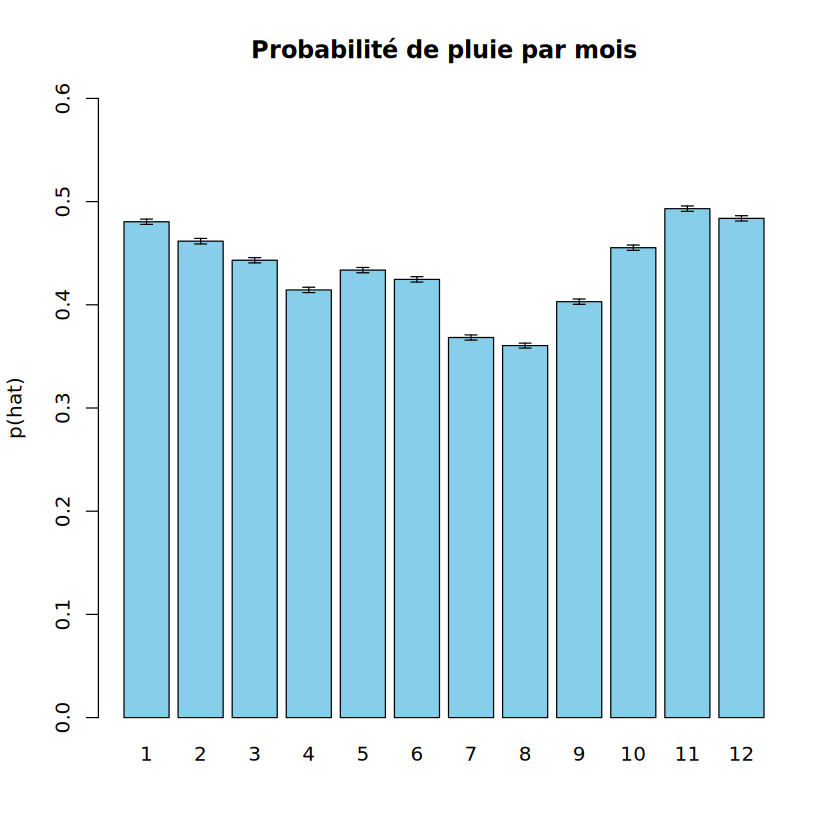

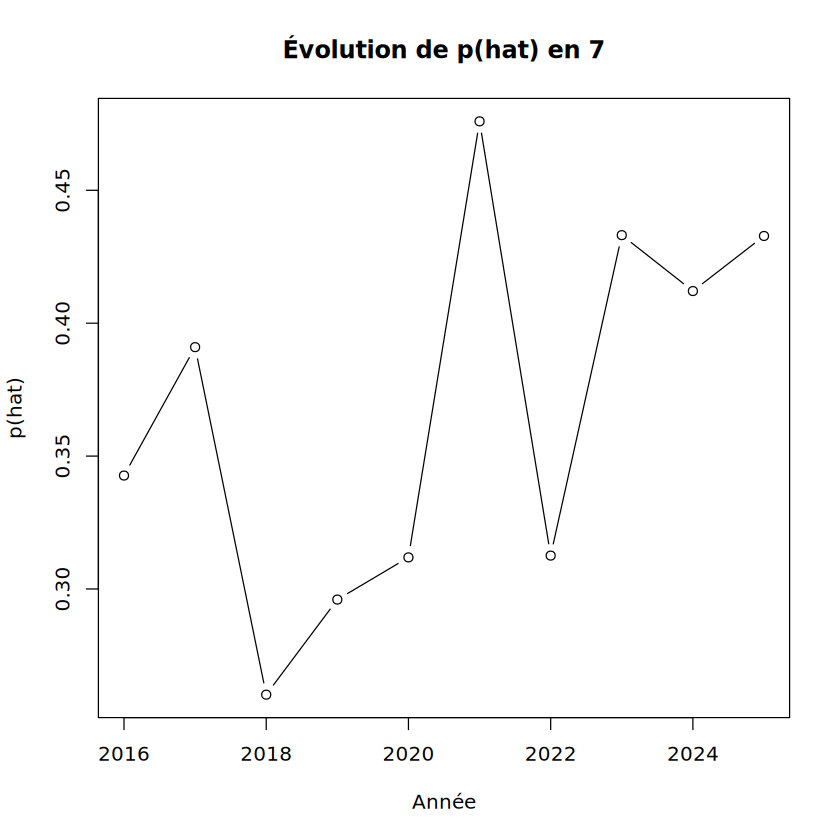

In [97]:
#Vision mois 

df <- data_weather

# Créer la variable pluie en remplaçant les NA par 0
df$rain <- ifelse(is.na(df$Précipitations.dans.les.24.dernières.heures), 
                  0, ifelse(df$Précipitations.dans.les.24.dernières.heures > 0, 1, 0))

# Liste des mois
months <- sort(unique(df$mois_de_l_annee))

result <- data.frame(month = character(), n = numeric(), rainy_days = numeric(), p_hat = numeric(), ci_lower = numeric(), ci_upper = numeric())

for (m in months) {
  subset <- df[df$mois_de_l_annee == m, ]
  n <- sum(!is.na(subset$rain))       
  r <- sum(subset$rain, na.rm = TRUE) 
  if (n > 0) {
    p <- r / n
    ci <- binom.test(r, n)$conf.int
    result <- rbind(result, data.frame(
      month = m,
      n = n,
      rainy_days = r,
      p_hat = p,
      ci_lower = ci[1],
      ci_upper = ci[2]
    ))
  }
}

print(result)

# Attribution des saisons
par(bg = "white")
bar_centers <- barplot(result$p_hat, names.arg = result$month, ylim = c(0, 0.6),
                       col = "skyblue", main = "Probabilité de pluie par mois",
                       ylab = "p(hat)")

arrows(x0 = bar_centers, y0 = result$ci_lower,
       x1 = bar_centers, y1 = result$ci_upper,
       angle = 90, code = 3, length = 0.05)

df$season <- ifelse(df$mois_de_l_annee %in% c("12","01","02"), "Hiver",
             ifelse(df$mois_de_l_annee %in% c("3","4","5"), "Printemps",
             ifelse(df$mois_de_l_annee %in% c("6","7","8"), "Été", "Automne")))

seasons <- unique(df$season)
season_result <- data.frame(season=character(), n=numeric(), rainy_days=numeric(), p_hat=numeric())

for (s in seasons) {
  subset <- df[df$season == s, ]
  n <- sum(!is.na(subset$rain))
  r <- sum(subset$rain, na.rm = TRUE)
  season_result <- rbind(season_result, data.frame(season=s, n=n, rainy_days=r, p_hat=r/n))
}

print(season_result)


df <- data_weather
df$year <- substr(df$Date, 1, 4)  

df$rain <- ifelse(is.na(df$Précipitations.dans.les.24.dernières.heures), 
                  0, ifelse(df$Précipitations.dans.les.24.dernières.heures > 0, 1, 0))

# Liste des ANNÉES
years <- sort(unique(df$year))

# Liste des mois
months <- sort(unique(df$mois_de_l_annee))
example_month <- months[7]  

year_result <- data.frame(year=character(), n=numeric(), rainy_days=numeric(), p_hat=numeric())

for (y in years) {
  subset <- df[df$year == y & df$mois_de_l_annee == example_month, ]
  n <- sum(!is.na(subset$rain))
  r <- sum(subset$rain, na.rm = TRUE)
  if (n > 0) {
    year_result <- rbind(year_result, data.frame(year=y, n=n, rainy_days=r, p_hat=r/n))
  }
}

print(year_result)

par(bg = "white")
plot(as.numeric(year_result$year), year_result$p_hat, type="b",
     main=paste("Évolution de p(hat) en", example_month),
     xlab="Année", ylab="p(hat)")

Globalement, l’estimation de la probabilité de pluie révèle une saisonnalité nette, avec des mois d’hiver significativement plus humides que l’été, au dela de l’intervalle de confiance, conclusion vrai aussi lorsqu’on segmente par mois. Par contre lorsque l’on segmente par année, on observe une vrai fluctuation entre les mois d’une année à l’autre, sans tendance par contre évidente à la hausse ou à la baisse à ce stade. Une analyse plus ciblée par station ou par seuil d’intensité permettrait d’affiner ces conclusions si nécessaire. On pourait aussi s’interesser au conséquence du changement climatique mais une échelle de temps plus grande serait nécéssaire.